In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

task_to_metrics = {
    "cola": ["matthews_correlation"],
    "mnli": ["accuracy"],
    "mnli_mismatched": ["accuracy"],
    "mnli_matched": ["accuracy"],
    "mnli-mm": ["accuracy"],
    "mrpc": ["accuracy", "f1"],
    "qnli": ["accuracy"],
    "qqp": ["accuracy", "f1"],
    "rte": ["accuracy"],
    "sst2": ["accuracy"],
    "stsb": ["pearson", "spearmanr"],
    "wnli": ["accuracy"],
    "hans": ["accuracy"],
}


In [25]:
from datasets import load_dataset

In [28]:
load_dataset("xnli", "es")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Dataset xnli downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/xnli/es/1.1.0/818164464f9c9fd15776ca8a00423b074344c3e929d00a2c1a84aa5a50c928bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 392702
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 5010
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2490
    })
})

In [12]:
df = pd.read_csv ("../glue_evaluation_results.csv")

In [19]:
df[df["reinit_cls_only"] == True].groupby('model')['performance'].mean()

model
deberta-v3-base     0.817599
roberta-base        0.783587
xlm-roberta-base    0.704790
Name: performance, dtype: float64

In [20]:
df[df["train_embeddings_only"] == True].groupby('model')['performance'].mean()

model
deberta-v3-base     0.459735
roberta-base        0.396132
xlm-roberta-base    0.365041
Name: performance, dtype: float64

In [21]:
df[df["tokenizer"] == "bert-base-japanese"].groupby('model')['performance'].mean()

model
deberta-v3-base     0.461953
roberta-base        0.459894
xlm-roberta-base    0.427667
Name: performance, dtype: float64

In [3]:
# df.to_csv("../glue_evaluation_results_updated.csv", index=False)

In [4]:
def query_df(
    df,
    task_name = "sst2",
    lr = 2e-05,
    midtuning = False,
    tokenizer = "roberta-base", # options: 'albert-base-v2', 'bert-base-cased'
    galactic_shift = None, # options: 'en~fr@N~fr@V', 'en~fr@N~jaktc@V', 'en~jaktc@N~jaktc@V'
    reinit_embedding = False,
    reverse_order = False,
    random_order = False,
    token_swap = False,
    word_swap = False,
    metrics = "accuracy",
    seed=42,
):
    SPLIT = "eval"
    MODEL = "roberta-base"
    if galactic_shift is None:
        return df[
            (df["glue_task"]==task_name)&
            (df["learning_rate"]==lr)&
            (df["tokenizer"]==tokenizer)&
            (df["midtuning"]==midtuning)&
            (df['galactic_shift'].isna())&
            (df['reinit_embedding']==reinit_embedding)&
            (df['reverse_order']==reverse_order)&
            (df['random_order']==random_order)&
            (df['token_swap']==token_swap)&
            (df['word_swap']==word_swap)&
            (df['metrics']==metrics)&
            (df['seed']==seed)
        ]["performance"].values
    else:
        return df[
            (df["glue_task"]==task_name)&
            (df["learning_rate"]==lr)&
            (df["tokenizer"]==tokenizer)&
            (df["midtuning"]==midtuning)&
            (df['galactic_shift']==galactic_shift)&
            (df['reinit_embedding']==reinit_embedding)&
            (df['reverse_order']==reverse_order)&
            (df['random_order']==random_order)&
            (df['token_swap']==token_swap)&
            (df['word_swap']==word_swap)&
            (df['metrics']==metrics)&
            (df['seed']==seed)
        ]["performance"].values

def query_set(
    df,
    task_name = "sst2",
    tokenizer = "roberta-base", # options: 'albert-base-v2', 'bert-base-cased'
    galactic_shift = None, # options: 'en~fr@N~fr@V', 'en~fr@N~jaktc@V', 'en~jaktc@N~jaktc@V'
    reinit_embedding = False,
    reverse_order = False,
    random_order = False,
    token_swap = False,
    word_swap = False,
    metrics = "accuracy",
    seeds = [42, 66, 88],
):
    seeds_results = []
    for seed in seeds:
        seed_results = [
            [query_df(
                df, task_name=task_name, midtuning=False, lr=2e-05, galactic_shift=galactic_shift, 
                reinit_embedding=reinit_embedding, reverse_order=reverse_order, random_order=random_order,
                token_swap=token_swap, word_swap=word_swap, tokenizer=tokenizer, metrics=metrics,
                seed=seed
            )[0],
            query_df(
                df, task_name=task_name, midtuning=False, lr=4e-05, galactic_shift=galactic_shift, 
                reinit_embedding=reinit_embedding, reverse_order=reverse_order, random_order=random_order,
                token_swap=token_swap, word_swap=word_swap, tokenizer=tokenizer, metrics=metrics,
                seed=seed
            )[0]],
            [query_df(
                df, task_name=task_name, midtuning=True, lr=2e-05, galactic_shift=galactic_shift, 
                reinit_embedding=reinit_embedding, reverse_order=reverse_order, random_order=random_order,
                token_swap=token_swap, word_swap=word_swap, tokenizer=tokenizer, metrics=metrics,
                seed=seed
            )[0],
            query_df(
                df, task_name=task_name, midtuning=True, lr=4e-05, galactic_shift=galactic_shift, 
                reinit_embedding=reinit_embedding, reverse_order=reverse_order, random_order=random_order,
                token_swap=token_swap, word_swap=word_swap, tokenizer=tokenizer, metrics=metrics,
                seed=seed
            )[0]],
        ]
        seeds_results += [seed_results]
    # print(np.array(seeds_results))
    return np.array(seeds_results)

In [186]:
task_name = "stsb"
metrics = task_to_metrics[task_name][0]
mean_results = []
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, random_order=True, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, reverse_order=True, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~fr@V", metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~jaktc@N~jaktc@V", metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~jaktc@V", metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="albert-base-v2", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="flaubert_base_cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-dutch-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, token_swap=True, metrics=metrics), axis=2), axis=0)]
mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, word_swap=True, metrics=metrics), axis=2), axis=0)]

std_results = []
std_results += [np.std(np.amax(query_set(df, task_name=task_name, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, random_order=True, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, reverse_order=True, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~fr@V", metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, galactic_shift="en~jaktc@N~jaktc@V", metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~jaktc@V", metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, tokenizer="albert-base-v2", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, tokenizer="flaubert_base_cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-dutch-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, token_swap=True, metrics=metrics), axis=2), axis=0)]
std_results += [np.std(np.amax(query_set(df, task_name=task_name, word_swap=True, metrics=metrics), axis=2), axis=0)]

In [187]:
mean_results

[array([0.89081919, 0.89337873]),
 array([0.87333124, 0.87610997]),
 array([0.87199687, 0.871683  ]),
 array([0.8803997, 0.8878722]),
 array([0.88348403, 0.88833694]),
 array([0.88041165, 0.88937504]),
 array([0.0566952 , 0.76230538]),
 array([0.05806481, 0.73354939]),
 array([0.05509528, 0.7739386 ]),
 array([0.0873132 , 0.78711234]),
 array([0.08394271, 0.78303197]),
 array([0.73652149, 0.77317331]),
 array([0.76556683, 0.78919954])]

/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


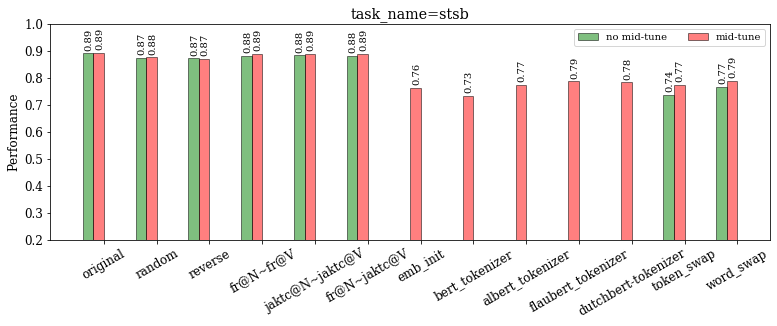

In [189]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("ggplot")

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_axes([0,0,1,1])

    data_1 = []
    data_2 = []
    for res in mean_results:
        data_1 += [res[0]]
        data_2 += [res[1]]
    
    groups = [
        data_1, 
        data_2,
    ]
    group_names = ['no mid-tune', 'mid-tune',]
    groupby_names = [
        "original", "random", "reverse", "fr@N~fr@V", "jaktc@N~jaktc@V", "fr@N~jaktc@V", 
         "emb_init", "bert_tokenizer", "albert_tokenizer", "flaubert_tokenizer", "dutchbert-tokenizer", 
         "token_swap", "word_swap",
    ]

    x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])  # the label
    width = 0.2  # the width of the bars
    rects0 = ax.bar(x - 1.5*width, groups[0], width, label=group_names[0], edgecolor='black', color="green", alpha=0.5)
    rects1 = ax.bar(x - width/2, groups[1], width, label=group_names[1], edgecolor='black', color="red", alpha=0.5)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(groupby_names, rotation=30)
    ax.legend(
        loc='upper right', fontsize=10, ncol=2
    )
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(0.02+ rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10, rotation=90)

    autolabel(rects0)
    autolabel(rects1)
    
    fig.tight_layout()

    ax.set_facecolor("white")
    plt.title(f"task_name={task_name}")
    plt.ylim(0.2,1.0)
    plt.show()
    # plt.savefig("../../data-files-updated/Analysis-Result/action_sequence_length",dpi=1000, bbox_inches='tight')

In [5]:
mega_mean_results = []
mega_std_results = []
for task_name in ["cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]:
    metrics = task_to_metrics[task_name][0]
    mean_results = []
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, random_order=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, reverse_order=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~fr@V", metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~jaktc@N~jaktc@V", metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~jaktc@V", metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="albert-base-v2", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="flaubert_base_cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-dutch-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, token_swap=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, word_swap=True, metrics=metrics), axis=2), axis=0)]

    std_results = []
    std_results += [np.amax(query_set(df, task_name=task_name, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, random_order=True, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, reverse_order=True, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~fr@V", metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, galactic_shift="en~jaktc@N~jaktc@V", metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~jaktc@V", metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, reinit_embedding=True, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-cased", reinit_embedding=True, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, tokenizer="albert-base-v2", reinit_embedding=True, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, tokenizer="flaubert_base_cased", reinit_embedding=True, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-dutch-cased", reinit_embedding=True, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, token_swap=True, metrics=metrics), axis=2)]
    std_results += [np.amax(query_set(df, task_name=task_name, word_swap=True, metrics=metrics), axis=2)]
    mega_mean_results += [mean_results]
    mega_std_results += [std_results]
mega_mean_results = np.array(mega_mean_results)
mega_std_results = np.array(mega_std_results)

In [6]:
avg_mega_std_results = np.mean(mega_std_results, axis=0)
avg_mega_std_results = np.std(avg_mega_std_results, axis=1)
avg_mega_mean_results = np.mean(mega_mean_results, axis=0)

In [7]:
avg_mega_mean_results = avg_mega_mean_results.tolist()
avg_mega_std_results = avg_mega_std_results.tolist()

/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


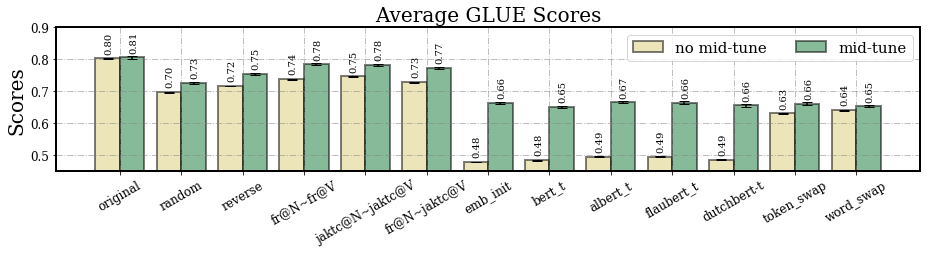

In [247]:
# plt.style.use("ggplot")

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(12, 2))
    ax = fig.add_axes([0,0,1,1])

    data_1 = []
    data_2 = []
    for res in avg_mega_mean_results:
        data_1 += [res[0]]
        data_2 += [res[1]]
    groups = [
        data_1, 
        data_2,
    ]
    
    std_data_1 = []
    std_data_2 = []
    for res in avg_mega_std_results:
        std_data_1 += [res[0]]
        std_data_2 += [res[1]]
    std_groups = [
        std_data_1, 
        std_data_2,
    ]
    
    group_names = ['no mid-tune', 'mid-tune',]
    groupby_names = [
        "original", "random", "reverse", "fr@N~fr@V", "jaktc@N~jaktc@V", "fr@N~jaktc@V", 
         "emb_init", "bert_t", "albert_t", "flaubert_t", "dutchbert-t", 
         "token_swap", "word_swap",
    ]

    x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])  # the label
    width = 0.4  # the width of the bars
    rects0 = ax.bar(x - width/2, groups[0], yerr=std_data_1[0], width=width, label=group_names[0], 
                    edgecolor='black', color="#ddcc77", alpha=0.5, linewidth=2,
                    ecolor='black', capsize=5, align='center'
                   )
    rects1 = ax.bar(x + width/2, groups[1], yerr=std_data_2[0], width=width, label=group_names[1], 
                    edgecolor='black', color="#117733", alpha=0.5, linewidth=2,
                    ecolor='black', capsize=5, align='center'
                   )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(groupby_names, rotation=30)
    ax.legend(
        loc='upper right', fontsize=15, ncol=2
    )
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(0.02+ rect.get_x() + rect.get_width() / 2, height+0.005),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points", color="black",
                        ha='center', va='bottom', fontsize=10, rotation=90)

    autolabel(rects0)
    autolabel(rects1)
    
    fig.tight_layout()

    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    
    ax.set_facecolor("white")
    plt.title(f"Average GLUE Scores", fontsize=20)
    plt.ylim(0.45,0.9)
    plt.show()
    # plt.savefig("../../data-files-updated/Analysis-Result/action_sequence_length",dpi=1000, bbox_inches='tight')

/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


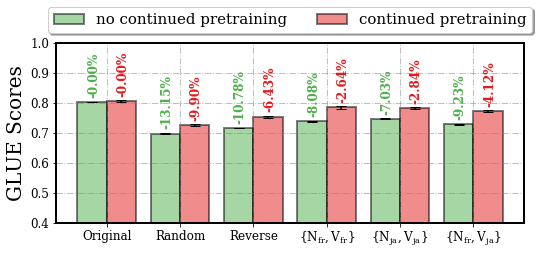

In [19]:
# plt.style.use("ggplot")

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_axes([0,0,1,1])

    data_1 = []
    data_2 = []
    for res in avg_mega_mean_results[:6]:
        data_1 += [res[0]]
        data_2 += [res[1]]
    groups = [
        data_1, 
        data_2,
    ]
    
    std_data_1 = []
    std_data_2 = []
    for res in avg_mega_std_results[:6]:
        std_data_1 += [res[0]]
        std_data_2 += [res[1]]
    std_groups = [
        std_data_1, 
        std_data_2,
    ]
    
    group_names = ['no continued pretraining', 'continued pretraining',]
    groupby_names = [
        "Original", "Random", "Reverse", "{$N_{fr},V_{fr}$}", "{$N_{ja},V_{ja}$}", "{$N_{fr},V_{ja}$}", 
         "emb_init", "bert_t", "albert_t", "flaubert_t", "dutchbert-t", 
         "token_swap", "word_swap",
    ][:6]

    standard_groups1 = []
    standard_groups2 = []
    for num in groups[0]:
        standard_groups1.append(((num-groups[0][0])/groups[0][0])*100)
    for num in groups[1]:
        standard_groups2.append(((num-groups[1][0])/groups[1][0])*100)
    
    x = np.array([0, 1, 2, 3, 4, 5, ])  # the label
    width = 0.4  # the width of the bars
    rects0 = ax.bar(x - width/2, groups[0], yerr=std_data_1[0], width=width,label=group_names[0], 
                    edgecolor='black', color="#4daf4a", alpha=0.5, linewidth=2,
                    ecolor='black', capsize=5, align='center'
                   )
    rects1 = ax.bar(x + width/2, groups[1], yerr=std_data_2[0], width=width, label=group_names[1], 
                    edgecolor='black', color="#e41a1c", alpha=0.5, linewidth=2,
                    ecolor='black', capsize=5, align='center'
                   )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('GLUE Scores', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(groupby_names, fontsize=12)
    ax.legend(
        loc='upper center', fontsize=15, ncol=2,
        bbox_to_anchor=(0.5, 1.24),
        fancybox=True, shadow=True
    )
    def autolabel(rects, numbers, color="black"):
        """Attach a text label above each bar in *rects*, displaying its height."""
        index = 0
        for rect in rects:
            height = rect.get_height()
            if index == 0:
                ax.annotate('-0.00%',
                            xy=(0.02+ rect.get_x() + rect.get_width() / 2, height+0.005),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", color=color, weight='bold',
                            ha='center', va='bottom', fontsize=12, rotation=90)
            else:
                ax.annotate('{:.2f}%'.format(numbers[index]),
                            xy=(0.02+ rect.get_x() + rect.get_width() / 2, height+0.005),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", color=color, weight='bold',
                            ha='center', va='bottom', fontsize=12, rotation=90)
            index += 1
            
    autolabel(rects0, standard_groups1, color="#4daf4a")
    autolabel(rects1, standard_groups2, color="#e41a1c")
    
    fig.tight_layout()

    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    
    ax.set_facecolor("white")
    # plt.title(f"GLUE Scores with Syntactic Shifts", fontsize=20)
    plt.ylim(0.4,1.0)
    # plt.show()
    plt.savefig("../data-files/syntactic-shifts.png",dpi=1000, bbox_inches='tight')

/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


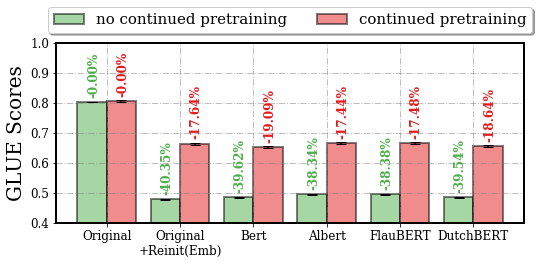

In [20]:
# plt.style.use("ggplot")

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_axes([0,0,1,1])

    data_1 = []
    data_2 = []
    for res in [
        avg_mega_mean_results[0],avg_mega_mean_results[6], 
        avg_mega_mean_results[7], avg_mega_mean_results[8], 
        avg_mega_mean_results[9], avg_mega_mean_results[10]
    ]:
        data_1 += [res[0]]
        data_2 += [res[1]]
    groups = [
        data_1, 
        data_2,
    ]

    std_data_1 = []
    std_data_2 = []
    for res in [
        avg_mega_std_results[0],avg_mega_std_results[6],
        avg_mega_std_results[7],avg_mega_std_results[8],
        avg_mega_std_results[9],avg_mega_std_results[10],
    ]:
        std_data_1 += [res[0]]
        std_data_2 += [res[1]]
    std_groups = [
        std_data_1, 
        std_data_2,
    ]
    
    group_names = ['no continued pretraining', 'continued pretraining',]
    groupby_names = ["Original", "Original\n+Reinit(Emb)", "Bert", "Albert", "FlauBERT", "DutchBERT"]

    standard_groups1 = []
    standard_groups2 = []
    for num in groups[0]:
        standard_groups1.append(((num-groups[0][0])/groups[0][0])*100)
    for num in groups[1]:
        standard_groups2.append(((num-groups[1][0])/groups[1][0])*100)
    
    x = np.array([0, 1, 2, 3, 4, 5, ])  # the label
    width = 0.4  # the width of the bars
    rects0 = ax.bar(x - width/2, groups[0], yerr=std_data_1[0], width=width,label=group_names[0], 
                    edgecolor='black', color="#4daf4a", alpha=0.5, linewidth=2,
                    ecolor='black', capsize=5, align='center'
                   )
    rects1 = ax.bar(x + width/2, groups[1], yerr=std_data_2[0], width=width, label=group_names[1], 
                    edgecolor='black', color="#e41a1c", alpha=0.5, linewidth=2,
                    ecolor='black', capsize=5, align='center'
                   )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('GLUE Scores', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(groupby_names, fontsize=12)
    ax.legend(
        loc='upper center', fontsize=15, ncol=2,
        bbox_to_anchor=(0.5, 1.24),
        fancybox=True, shadow=True
    )
    def autolabel(rects, numbers, color="black"):
        """Attach a text label above each bar in *rects*, displaying its height."""
        index = 0
        for rect in rects:
            height = rect.get_height()
            if index == 0:
                ax.annotate('-0.00%',
                            xy=(0.02+ rect.get_x() + rect.get_width() / 2, height+0.005),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", color=color, weight='bold',
                            ha='center', va='bottom', fontsize=12, rotation=90)
            else:
                ax.annotate('{:.2f}%'.format(numbers[index]),
                            xy=(0.02+ rect.get_x() + rect.get_width() / 2, height+0.005),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", color=color, weight='bold',
                            ha='center', va='bottom', fontsize=12, rotation=90)
            index += 1
            
    autolabel(rects0, standard_groups1, color="#4daf4a")
    autolabel(rects1, standard_groups2, color="#e41a1c")
    
    fig.tight_layout()

    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    
    ax.set_facecolor("white")
    # plt.title(f"GLUE Scores with Tokenizer Substitutions", fontsize=20)
    plt.ylim(0.4,1.0)
    # plt.show()
    plt.savefig("../data-files/tokenizer-substitutions.png",dpi=1000, bbox_inches='tight')

In [358]:
grouped_results = mega_std_results.transpose(1, 0, 2, 3).reshape(13, -1, 2)

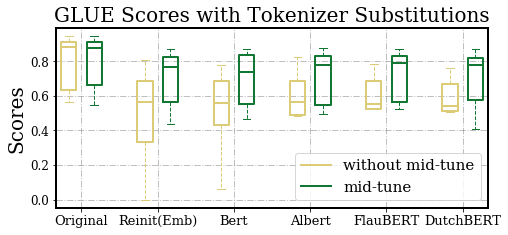

In [375]:
from pylab import setp

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(6, 2.5))
    ax = fig.add_axes([0,0,1,1])

    plt.title(f"GLUE Scores with Tokenizer Substitutions", fontsize=20)

    def setBoxColors(bp):
        setp(bp['boxes'][0], color='#ddcc77')
        setp(bp['caps'][0], color='#ddcc77')
        setp(bp['caps'][1], color='#ddcc77')
        setp(bp['whiskers'][0], color='#ddcc77')
        setp(bp['whiskers'][1], color='#ddcc77')
        setp(bp['medians'][0], color='#ddcc77')

        setp(bp['boxes'][1], color='#117733')
        setp(bp['caps'][2], color='#117733')
        setp(bp['caps'][3], color='#117733')
        setp(bp['whiskers'][2], color='#117733')
        setp(bp['whiskers'][3], color='#117733')
        setp(bp['medians'][1], color='#117733')
    
    # first boxplot pair
    bp = ax.boxplot(
        [grouped_results[0][:,0],grouped_results[0][:,1]], positions = [1, 2], widths = 0.6,
        showfliers=False,
        boxprops=dict(color="black",linewidth=2),
        medianprops=dict(color="red",linewidth=2),
        capprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1,linestyle='--')
    )
    setBoxColors(bp)

    # second boxplot pair
    bp = ax.boxplot(
        [grouped_results[6][:,0],grouped_results[6][:,1]], positions = [4, 5], widths = 0.6,
        showfliers=False,
        boxprops=dict(color="black",linewidth=2),
        medianprops=dict(color="red",linewidth=2),
        capprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1,linestyle='--')
    )
    setBoxColors(bp)

    # thrid boxplot pair
    bp = ax.boxplot(
        [grouped_results[7][:,0],grouped_results[7][:,1]], positions = [7, 8], widths = 0.6,
        showfliers=False,
        boxprops=dict(color="black",linewidth=2),
        medianprops=dict(color="red",linewidth=2),
        capprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1,linestyle='--')
    )
    setBoxColors(bp)
    
    bp = ax.boxplot(
        [grouped_results[8][:,0],grouped_results[8][:,1]], positions = [10, 11], widths = 0.6,
        showfliers=False,
        boxprops=dict(color="black",linewidth=2),
        medianprops=dict(color="red",linewidth=2),
        capprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1,linestyle='--')
    )
    setBoxColors(bp)
    
    bp = ax.boxplot(
        [grouped_results[9][:,0],grouped_results[9][:,1]], positions = [13, 14], widths = 0.6,
        showfliers=False,
        boxprops=dict(color="black",linewidth=2),
        medianprops=dict(color="red",linewidth=2),
        capprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1,linestyle='--')
    )
    setBoxColors(bp)
    
    bp = ax.boxplot(
        [grouped_results[10][:,0],grouped_results[10][:,1]], positions = [16, 17], widths = 0.6,
        showfliers=False,
        boxprops=dict(color="black",linewidth=2),
        medianprops=dict(color="red",linewidth=2),
        capprops=dict(linewidth=1),
        whiskerprops=dict(linewidth=1,linestyle='--')
    )
    setBoxColors(bp)

    ax.legend(
        [bp["boxes"][0], bp["boxes"][1]], ['without mid-tune', 'mid-tune'], 
        loc='lower right',
        fontsize=15
    )
    
    plt.xticks(
        [1.5, 4.5, 7.5, 10.5, 13.5, 16.5], 
        ["Original", "Reinit(Emb)", "Bert", "Albert", "FlauBERT", "DutchBERT"], 
        fontsize=13
    )
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.set_ylabel('Scores', fontsize=20)
    
    # plt.show()
    plt.savefig("../data-files/tokenizer-substitutions.png",dpi=1000, bbox_inches='tight')
    
    

/afs/cs.stanford.edu/u/wuzhengx/.local/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


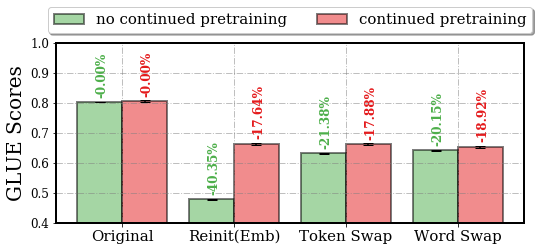

In [21]:
# plt.style.use("ggplot")

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_axes([0,0,1,1])

    data_1 = []
    data_2 = []
    filted_results = [avg_mega_mean_results[0]]
    filted_results += [avg_mega_mean_results[6]]
    filted_results += [avg_mega_mean_results[-2]]
    filted_results += [avg_mega_mean_results[-1]]
    
    filted_std = [avg_mega_std_results[0]]
    filted_std += [avg_mega_std_results[6]]
    filted_std += [avg_mega_std_results[-2]]
    filted_std += [avg_mega_std_results[-1]]
    
    for res in filted_results:
        data_1 += [res[0]]
        data_2 += [res[1]]
    groups = [
        data_1, 
        data_2,
    ]
    
    std_data_1 = []
    std_data_2 = []
    for res in filted_std:
        std_data_1 += [res[0]]
        std_data_2 += [res[1]]
    std_groups = [
        std_data_1, 
        std_data_2,
    ]
    
    standard_groups1 = []
    standard_groups2 = []
    for num in groups[0]:
        standard_groups1.append(((num-groups[0][0])/groups[0][0])*100)
    for num in groups[1]:
        standard_groups2.append(((num-groups[1][0])/groups[1][0])*100)
    
    group_names = ['no continued pretraining', 'continued pretraining',]
    groupby_names = [
        "Original", "Reinit(Emb)", "Token Swap", "Word Swap",
    ][:6]

    x = np.array([0, 1, 2, 3,])  # the label
    width = 0.4  # the width of the bars
    rects0 = ax.bar(x - width/2, groups[0], yerr=std_data_1[0], width=width,label=group_names[0], 
                    edgecolor='black', color="#4daf4a", alpha=0.5, linewidth=2,
                    ecolor='black', capsize=5, align='center'
                   )
    rects1 = ax.bar(x + width/2, groups[1], yerr=std_data_2[0], width=width, label=group_names[1], 
                    edgecolor='black', color="#e41a1c", alpha=0.5, linewidth=2,
                    ecolor='black', capsize=5, align='center'
                   )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('GLUE Scores', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(groupby_names, fontsize=15)
    ax.legend(
        loc='upper center', fontsize=15, ncol=2,
        bbox_to_anchor=(0.5, 1.24),
        fancybox=True, shadow=True
    )
    def autolabel(rects, numbers, color="black"):
        """Attach a text label above each bar in *rects*, displaying its height."""
        index = 0
        for rect in rects:
            height = rect.get_height()
            if index == 0:
                ax.annotate('-0.00%',
                            xy=(0.02+ rect.get_x() + rect.get_width() / 2, height+0.005),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", color=color, weight='bold',
                            ha='center', va='bottom', fontsize=12, rotation=90)
            else:
                ax.annotate('{:.2f}%'.format(numbers[index]),
                            xy=(0.02+ rect.get_x() + rect.get_width() / 2, height+0.005),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points", color=color, weight='bold',
                            ha='center', va='bottom', fontsize=12, rotation=90)
            index += 1
            
    autolabel(rects0, standard_groups1, color="#4daf4a")
    autolabel(rects1, standard_groups2, color="#e41a1c")
    
    fig.tight_layout()

    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    
    ax.set_facecolor("white")
    # plt.title(f"GLUE Scores with Scrambled Identities", fontsize=20)
    plt.ylim(0.4,1.0)
    # plt.show()
    plt.savefig("../data-files/identity-swap.png",dpi=1000, bbox_inches='tight')

Table-like Outputs

In [13]:
def query_per_task_results(task_name):
    metrics = task_to_metrics[task_name][0]
    mean_results = []
    
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, metrics=metrics), axis=2), axis=0)]
    
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="albert-base-v2", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="flaubert_base_cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-dutch-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, token_swap=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, word_swap=True, metrics=metrics), axis=2), axis=0)]
    
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, random_order=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, reverse_order=True, metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~fr@V", metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~jaktc@N~jaktc@V", metrics=metrics), axis=2), axis=0)]
    mean_results += [np.mean(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~jaktc@V", metrics=metrics), axis=2), axis=0)]



    std_results = []
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, metrics=metrics), axis=2), axis=0)]
    
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, tokenizer="albert-base-v2", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, tokenizer="flaubert_base_cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, tokenizer="bert-base-dutch-cased", reinit_embedding=True, metrics=metrics), axis=2), axis=0)]

    std_results += [np.std(np.amax(query_set(df, task_name=task_name, token_swap=True, metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, word_swap=True, metrics=metrics), axis=2), axis=0)]
    
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, random_order=True, metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, reverse_order=True, metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~fr@V", metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, galactic_shift="en~jaktc@N~jaktc@V", metrics=metrics), axis=2), axis=0)]
    std_results += [np.std(np.amax(query_set(df, task_name=task_name, galactic_shift="en~fr@N~jaktc@V", metrics=metrics), axis=2), axis=0)]


    return mean_results, std_results


In [14]:
groupby_names = [
    "Original", 
    "Reinit(Emb)", "Bert", "Albert", "FlauBERT", "DutchBERT", 
    "Token Swap", "Word Swap", 
    "Random", "Reverse", "fr-fr", "ja-ja", "fr-ja",  
]
task_names = ["cola", "mnli", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]
TASK_NAMES = ["CoLA", "MNLI", "MRPC", "QNLI", "QQP", "RTE", "SST-2", "STS-B", "WNLI"]

In [15]:
table_results = []
row_names = []
for i in range(0, len(task_names)):
    wmi_results = []
    mid_results = []
    per_task_results = query_per_task_results(task_names[i])
    for j in range(0, len(per_task_results[0])):
        wmi_results += ["{:.2f}".format(per_task_results[0][j][0])[1:]+"("+"{:.2f}".format(per_task_results[1][j][0])[1:]+")"]
        mid_results += ["{:.2f}".format(per_task_results[0][j][1])[1:]+"("+"{:.2f}".format(per_task_results[1][j][1])[1:]+")"]
    table_results += [wmi_results]
    table_results += [mid_results]
    row_names += [TASK_NAMES[i]]
    row_names += [f"{TASK_NAMES[i]}(MT)"]

In [16]:
df_results = pd.DataFrame(table_results, columns =groupby_names) 
df_results.index = row_names

In [17]:
print(df_results.to_latex()) 

\begin{tabular}{llllllllllllll}
\toprule
{} &  Original & Reinit(Emb) &      Bert &    Albert &  FlauBERT & DutchBERT & Token Swap & Word Swap &    Random &   Reverse &     fr-fr &     ja-ja &     fr-ja \\
\midrule
CoLA      &  .58(.01) &    .00(.00) &  .00(.00) &  .00(.00) &  .00(.00) &  .00(.00) &   .00(.00) &  .00(.00) &  .04(.05) &  .01(.01) &  .16(.01) &  .21(.01) &  .12(.01) \\
CoLA(MT)  &  .59(.01) &    .05(.07) &  .02(.02) &  .06(.05) &  .00(.00) &  .00(.00) &   .01(.01) &  .00(.00) &  .22(.04) &  .35(.01) &  .45(.03) &  .47(.01) &  .44(.01) \\
MNLI      &  .88(.00) &    .34(.01) &  .50(.08) &  .53(.03) &  .54(.01) &  .53(.01) &   .67(.01) &  .68(.00) &  .82(.00) &  .85(.00) &  .86(.00) &  .86(.00) &  .85(.00) \\
MNLI(MT)  &  .88(.00) &    .72(.01) &  .72(.01) &  .73(.00) &  .73(.01) &  .71(.00) &   .71(.01) &  .69(.00) &  .82(.00) &  .86(.00) &  .86(.00) &  .86(.00) &  .86(.00) \\
MRPC      &  .88(.01) &    .68(.00) &  .68(.00) &  .68(.00) &  .68(.00) &  .68(.00) &   .76(.01) 